In [1]:

"""""
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('/kaggle/input/skin-cancer-lesions-inzip/HAM10000_metadata.csv')
print(skin_df)

2024-03-21 06:57:11.431892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 06:57:11.431990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 06:57:11.596592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [2]:
SIZE=65

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [3]:
print("Class Labels:")
for label, cls in enumerate(le.classes_):
    print(f"Class '{cls}' has label {label}")

Class Labels:
Class 'akiec' has label 0
Class 'bcc' has label 1
Class 'bkl' has label 2
Class 'df' has label 3
Class 'mel' has label 4
Class 'nv' has label 5
Class 'vasc' has label 6


In [4]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

/tmp/ipykernel_34/3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


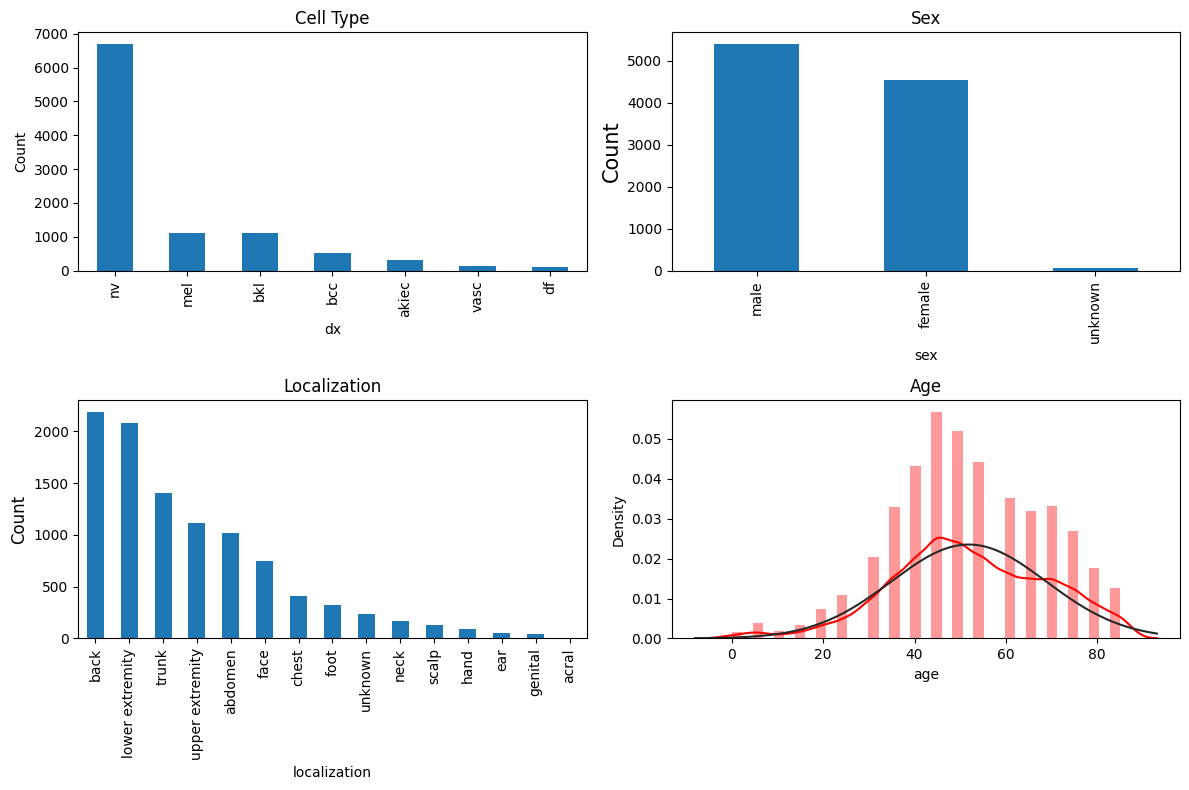

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [6]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [7]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

print(df_0.shape)

(327, 8)


In [8]:
n_samples=6500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
print(df_0_balanced.shape)


(6500, 8)


In [9]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    6500
1    6500
2    6500
3    6500
4    6500
5    6500
6    6500
Name: count, dtype: int64


In [11]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-lesions-inzip', '*', '*.jpg'))}

In [12]:
#Define the path and add as a new column

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [13]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[150, 112, 104], [160, 125, 117], [162, 127,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[139, 79, 89], [131, 68, 72], [131, 66, 67],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[92, 59, 60], [126, 91, 92], [156, 120, 119]..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[197, 141, 171], [204, 148, 174], [201, 142,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[200, 176, 199], [206, 178, 201], [203, 171,..."


In [16]:
skin_df_balanced.to_csv('Path_csv.csv', index=False)

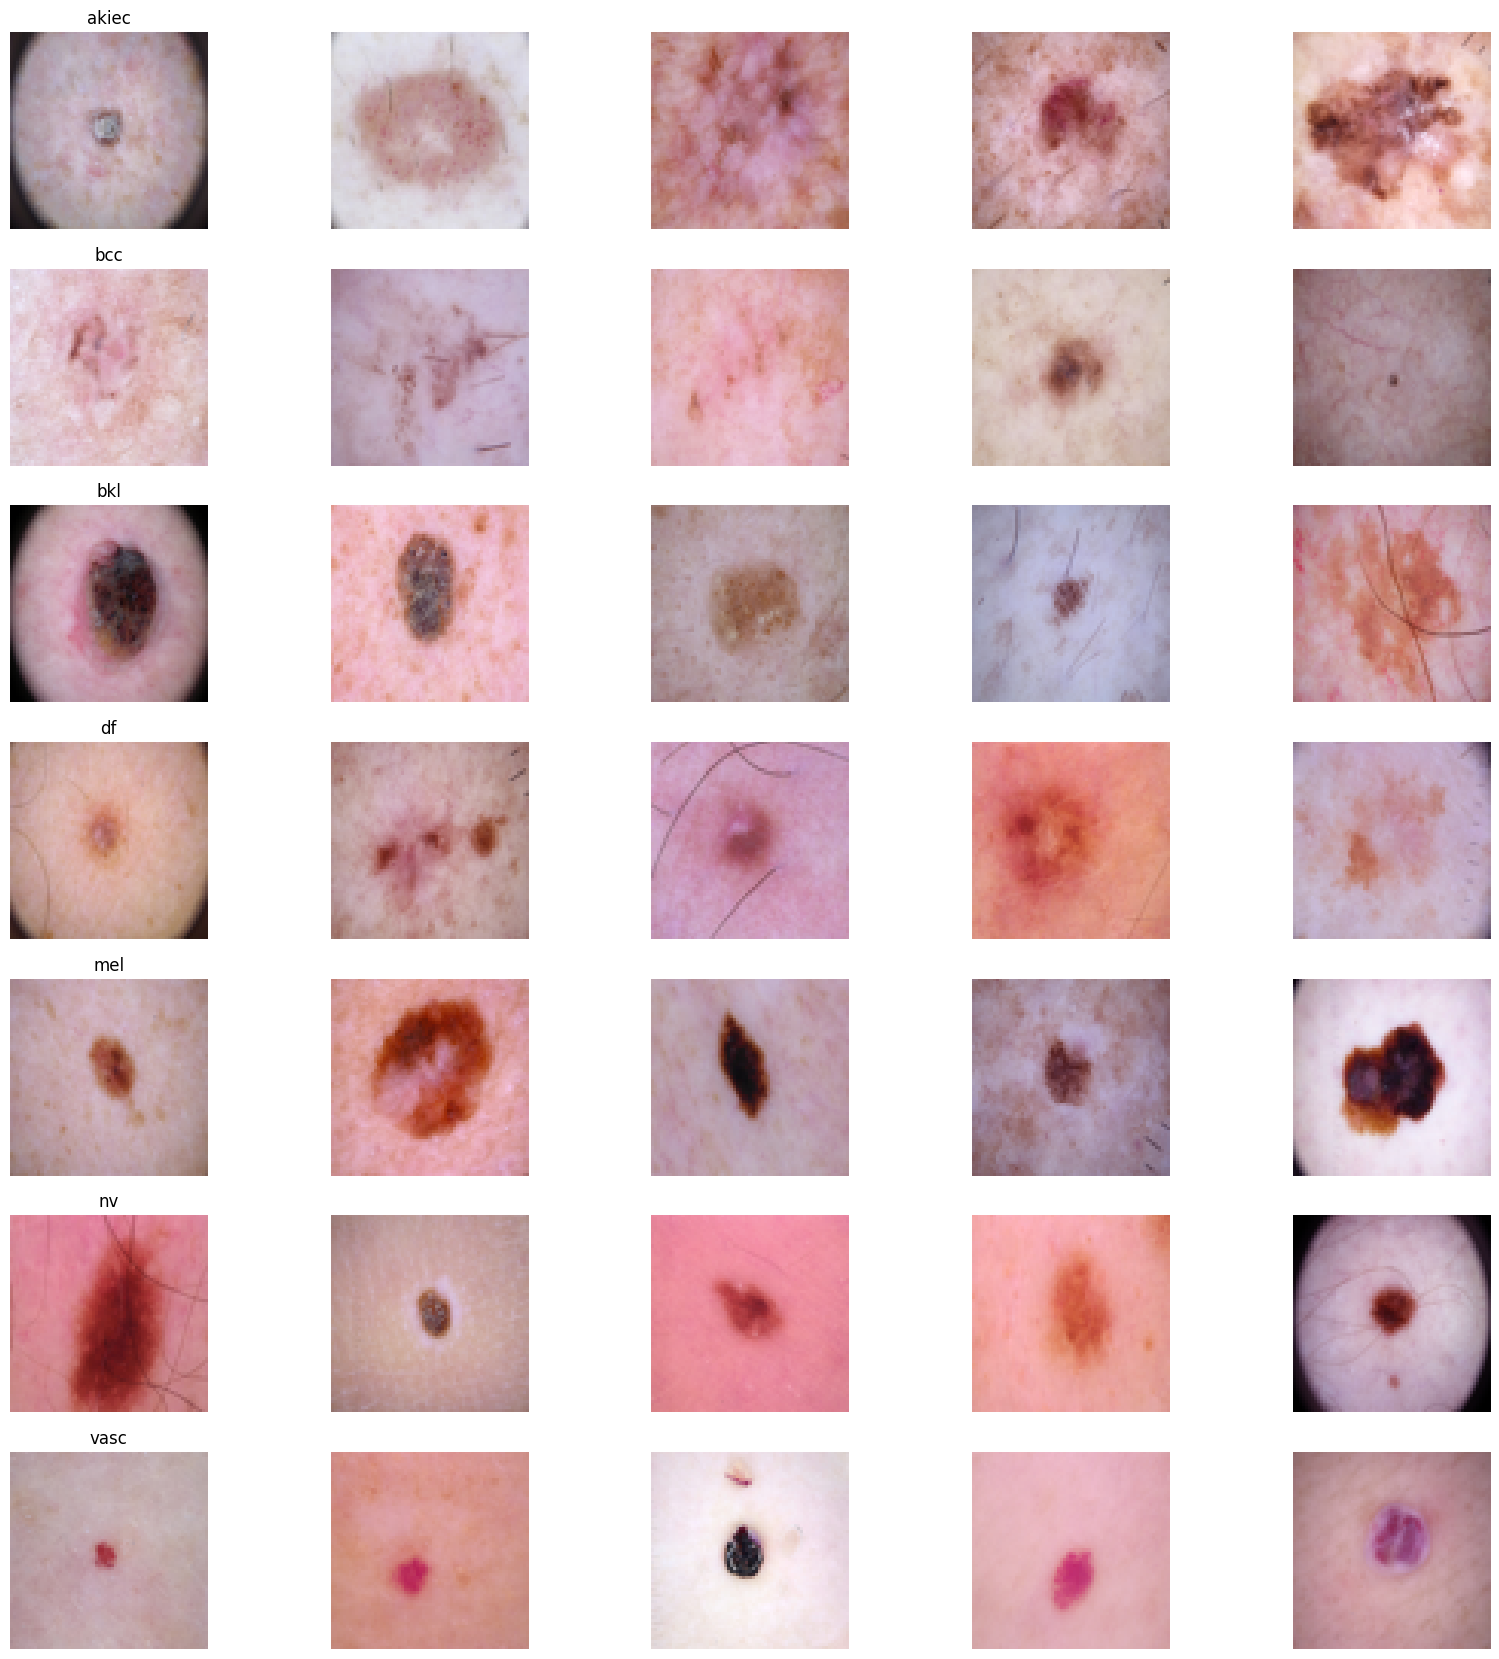

In [14]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [21]:
num_classes = 7

In [22]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
# #-------------------------------model------------------------------
from keras.models import Sequential
# from keras.layers import Dnse, Activation
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.applications import MobileNet

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Cast to float32
cast_to_float32 = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)

# Normalization layer
normalization = Normalization()(cast_to_float32)

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(normalization)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)

# Max pooling layer
pooling = MaxPooling2D(pool_size=(2, 2))(conv2)

# Dropout layer
dropout = Dropout(0.25)(pooling)

# Flatten layer
flatten = Flatten()(dropout)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(7, activation='softmax')(dense1)  # Assuming 7 classes

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=dense2)



# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 65, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 65, 65, 3)         0         
                                                                 
 normalization (Normalizati  (None, 65, 65, 3)         7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                          

In [24]:

# Compile the model
# Compile the model with Adam optimizer and learning rate
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size = 32,
    validation_data=(x_test, y_test))

Epoch 1/15


2024-03-20 04:58:47.696869: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1710910731.210334     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1067/1067 [==============================] - 23s 16ms/step - loss: 0.9891 - accuracy: 0.6370 - val_loss: 0.4748 - val_accuracy: 0.8359
Epoch 2/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.3095 - accuracy: 0.8922 - val_loss: 0.1698 - val_accuracy: 0.9385
Epoch 3/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.1332 - accuracy: 0.9553 - val_loss: 0.1528 - val_accuracy: 0.9515
Epoch 4/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.0821 - accuracy: 0.9720 - val_loss: 0.0854 - val_accuracy: 0.9788
Epoch 5/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.0729 - val_accuracy: 0.9829
Epoch 6/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.0574 - accuracy: 0.9815 - val_loss: 0.0738 - val_accuracy: 0.9844
Epoch 7/15
1067/1067 [==============================] - 15s 14ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.0801 - val_accura

In [25]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 [==============================] - 1s 3ms/step


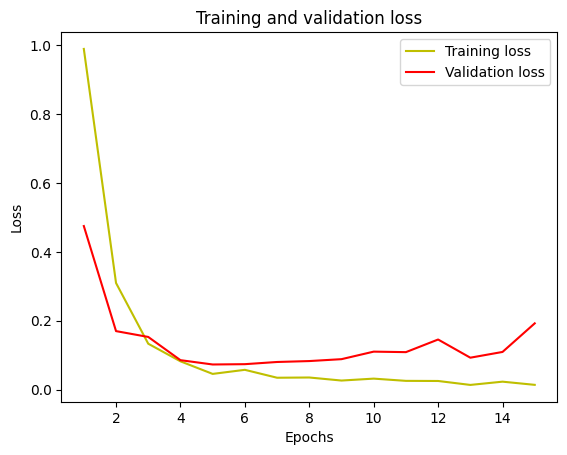

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

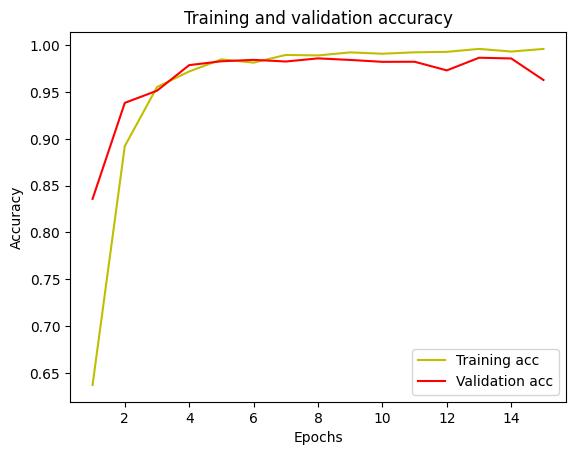

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 [==============================] - 1s 3ms/step


<Axes: >

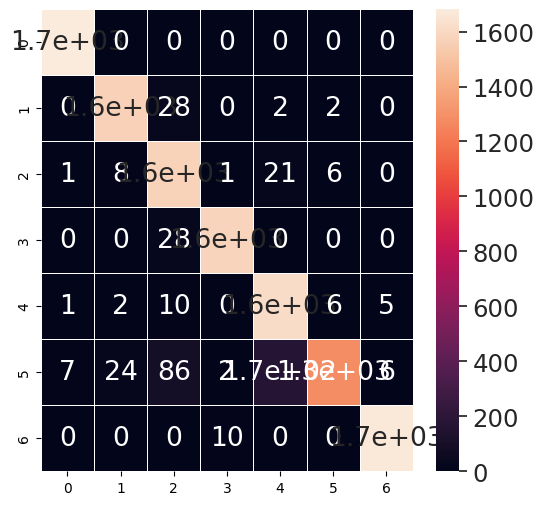

In [29]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report


# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1681
           1       0.98      0.98      0.98      1596
           2       0.91      0.98      0.94      1607
           3       0.99      0.98      0.99      1608
           4       0.90      0.99      0.94      1637
           5       0.99      0.82      0.89      1573
           6       0.99      0.99      0.99      1673

    accuracy                           0.96     11375
   macro avg       0.96      0.96      0.96     11375
weighted avg       0.97      0.96      0.96     11375



In [31]:
# Generate classification report
from sklearn.metrics import confusion_matrix, classification_report
report = classification_report(y_true, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1681
           1       0.98      0.98      0.98      1596
           2       0.91      0.98      0.94      1607
           3       0.99      0.98      0.99      1608
           4       0.90      0.99      0.94      1637
           5       0.99      0.82      0.89      1573
           6       0.99      0.99      0.99      1673

    accuracy                           0.96     11375
   macro avg       0.96      0.96      0.96     11375
weighted avg       0.97      0.96      0.96     11375



Text(0, 0.5, 'Fraction of incorrect predictions')

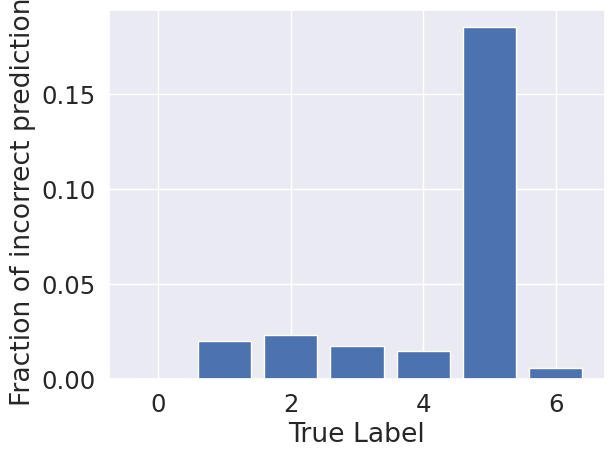

In [32]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [33]:
model.save('final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('/kaggle/working/final_model.h5')

# Load and preprocess the image
image = cv2.imread('/kaggle/input/skin-cancer-lesions-inzip/HAM10000_images_part_2/ISIC_0029363.jpg')
image = cv2.resize(image, (65, 65))  # Resize the image to match the input shape
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(image)

# Convert predictions to class labels
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print('Predicted class:', predicted_class)


1/1 [==============================] - 0s 232ms/step
Predicted class: [1]
